# GreenExplorer MCDA Pipeline Demo
A minimal, end‑to‑end notebook that shows how to:
1. Load the tourism CSVs already in your repo.
2. (Optionally) call the ChatGPT API to enrich each POI with the six sustainability indicators *z₁–z₆*.
3. Build an ELECTRE‑III decision matrix with **pyDecision** and get a ranking.
4. Refine the non‑dominated kernel with a soft‑AND Logic‑Scoring‑of‑Preference (LSP) utility.
5. Display the top‑k recommendations.

> ✨ **Tip for class projects** – treat this notebook as a scaffold: run the cells, read the comments, then plug in your real indicator functions and UI.”

## 📦 Install & import the specialised libraries
Uncomment the first cell the **first time** you run the notebook or whenever you rebuild the Docker image.

In [1]:
import os, json, pandas as pd, numpy as np
from dataloader import readTourismData

# MCDA libraries
from pyDecision.algorithm import electre_iii
from pymcdm.helpers import rankdata


### 1️⃣ Load the demo POI corpus

In [2]:
df = readTourismData('../data')   # adjust path if you moved the notebook
print(f'Total POIs loaded: {len(df):,}')
df.head()

Total POIs loaded: 300


,name,category,lat,lon,sustainability,popularity,municipality
0,La Sagrada Família,Monument,41.4036,2.1744,0.35,0.98,barcelona
1,Park Güell,Park,41.4145,2.1527,0.80,0.95,barcelona
2,Casa Batlló,Monument,41.3916,2.1649,0.40,0.92,barcelona
3,La Pedrera (Casa Milà),Monument,41.3954,2.1619,0.45,0.88,barcelona
4,Barcelona Cathedral,Historic,41.3839,2.1763,0.50,0.85,barcelona


### 2️⃣ Generate/attach the six sustainability indicators *(z₁–z₆)*
Below is a **placeholder** that shows how you *could* call the ChatGPT API in batch‑mode.
Replace the prompt with your own indicator derivation logic (API, heuristics, sensors, etc.).

In [14]:
from tqdm import tqdm
import pandas as pd, json, os, time, random
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()
client = OpenAI()

PROMPT_TEMPLATE = """
You are a sustainability analyst.  For the Point-of-Interest below,
return ONLY valid JSON with keys z1–z6 (floats 0–1).

Definitions (copy exactly):
• z1 = estimated CO2-kg per individual visit (lower = greener).
• z2 = current_visitors / carrying_capacity (lower = less crowded).
• z3 = entropy-based seasonality balance (higher = steadier flow).
• z4 = proportion of revenue retained locally (higher = better).
• z5 = crowd-adjusted heritage fragility (lower = safer for culture).
• z6 = overall physical & sensory accessibility (higher = inclusive).

POI:
Name: {name}
Category: {category}
Lat,Lon: {lat}, {lon}
Known sustainability proxy (0-1): {sustainability}
Popularity score (0-1): {popularity}
"""

SYSTEM_MSG = {
    "role": "system",
    "content": "You are a strict JSON generator. Output only valid JSON."
}

def gpt_enrich_row(row):
    prompt = PROMPT_TEMPLATE.format(**row)
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[SYSTEM_MSG, {"role": "user", "content": prompt}],
        temperature=0.1,
        response_format={"type": "json_object"}
    )
    return json.loads(resp.choices[0].message.content)

def enrich_dataframe(df):
    records = []
    for _, r in tqdm(df.iterrows(), total=len(df)):
        try:
            records.append(gpt_enrich_row(r))
        except Exception as e:
            print(f"⚠️  Skipped {r['name']}: {e}")
            records.append({f"z{i}": None for i in range(1, 7)})
    return pd.concat([df.reset_index(drop=True),
                      pd.DataFrame(records)], axis=1)

# usage
df = readTourismData("../data")
df = enrich_dataframe(df)


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [08:40<00:00,  1.74s/it]


In [15]:
# ── CELL ▒▒ Save enriched data ▒▒─────────────────────────────────────────────
# 1) master file with every POI + z-indicators
master_path = "../data/poi_all_enriched.csv"
df.to_csv(master_path, index=False)
print(f"✅  Master CSV written → {master_path}  ({len(df):,} rows)")

# 2) one CSV per municipality (keeps the original naming convention)
for muni, sub in df.groupby("municipality"):
    fname = f"../data/poi_{muni}_30_enriched.csv"
    sub.to_csv(fname, index=False)
    print(" • Saved", fname)


✅  Master CSV written → ../data/poi_all_enriched.csv  (300 rows)
 • Saved ../data/poi_barcelona_30_enriched.csv
 • Saved ../data/poi_besalu_30_enriched.csv
 • Saved ../data/poi_cadaques_30_enriched.csv
 • Saved ../data/poi_figueres_30_enriched.csv
 • Saved ../data/poi_girona_30_enriched.csv
 • Saved ../data/poi_lleida_30_enriched.csv
 • Saved ../data/poi_montblanc_30_enriched.csv
 • Saved ../data/poi_sitges_30_enriched.csv
 • Saved ../data/poi_tarragona_30_enriched.csv
 • Saved ../data/poi_vic_30_enriched.csv


### 3️⃣ Build the ELECTRE‑III decision matrix
We use **pyDecision** because it already implements the full ELECTRE family (I–TRI).
Weights, thresholds (q/p/v) and the λ‑cut come straight out of the research report.

In [35]:
!pip install pymcdm

In [89]:
import numpy as np, pandas as pd
from pyDecision.algorithm import electre_iii

# 1 ── criteria present in the dataframe
criteria = [f"z{i}" for i in range(1, 8)]

# 2 ── keep only rows that have the full indicator set
df_valid = df.dropna(subset=criteria).copy()
print(f"using {len(df_valid)} / {len(df)} rows with full indicators")

# 3 ── decision matrix (invert the three COST criteria → benefit form)
M = df_valid[criteria].to_numpy(float)

cost_idx = [0, 1, 4]                    # z1 (CO₂), z2 (overtourism), z5
M[:, cost_idx] = 1.0 - M[:, cost_idx]   # bigger = better for everything

# 4 ── ELECTRE-III parameters (same semantics as in the paper)
Q = np.full(7, 0.05)                    # indifference threshold
P = np.full(7, 0.20)                    # preference threshold
V = np.full(7, 0.50)                    # veto threshold

W = np.array([                          # weights from Table 6 (sum = 1)
    0.15, 0.12, 0.08,   # P1  Environment
    0.25,               # P2  Socio-economic
    0.20,               # P3  Culture
    0.10, 0.10 ])       # P4  Accessibility + Preference-fit

# 5 ── run ELECTRE-III
glob_C, cred, rank_D, *_ = electre_iii(M, P=P, Q=Q, V=V, W=W, graph=False)

# 6 ── convert labels “a1 … aN” → original dataframe indices
rank_map = {}                                 # df index → ordinal rank

for pos, tied_block in enumerate(rank_D, start=1):   # rank_D is descending
    labels = [lbl.strip() for lbl in tied_block.split(';')]
    for lbl in labels:                               # unpack ties
        alt_idx = int(lbl[1:]) - 1                   # "a19" → 18
        df_index = df_valid.index[alt_idx]           # original row label
        rank_map[df_index] = pos                     # same rank for all ties

# 7 ── write back
df["electre_rank"] = np.nan
df.loc[list(rank_map.keys()), "electre_rank"] = pd.Series(rank_map, dtype=float)

print("✅ electre_rank filled for",
      df["electre_rank"].notna().sum(), "rows")
df.sort_values("electre_rank").head(10)

using 300 / 300 rows with full indicators
✅ electre_rank filled for 300 rows


,name,category,lat,lon,sustainability,popularity,municipality,z1,z2,z3,z4,z5,z6,z7,electre_rank
14,Jardí Botànic de Barcelona,Nature,41.364300,2.156000,0.90,0.55,barcelona,0.3,0.4,0.7,0.8,0.2,0.9,0.55,1.0
20,Parc del Laberint d'Horta,Park,41.441300,2.138200,0.92,0.50,barcelona,0.3,0.4,0.7,0.8,0.2,0.9,0.50,2.0
289,Call Jueu (Jewish Quarter),Cultural,41.930676,2.254648,0.36,0.56,vic,0.4,0.5,0.7,0.8,0.3,0.9,0.56,3.0
18,Mercat de Santa Caterina,Market,41.386000,2.175400,0.60,0.60,barcelona,0.4,0.5,0.7,0.8,0.3,0.9,0.60,3.0
126,Eiffel Bridge (Pont de les Peixateries Velles),Bridge,41.986800,2.823600,0.94,0.69,girona,0.3,0.5,0.7,0.8,0.4,0.9,0.69,4.0
140,Passeig Arqueològic,Viewpoint,41.988200,2.827300,0.92,0.71,girona,0.3,0.5,0.8,0.9,0.4,0.7,0.71,5.0
56,Aigües de les Creus (Spring),Nature,42.201000,2.706000,0.58,0.50,besalu,0.4,0.6,0.7,0.8,0.3,0.9,0.50,6.0
48,Torre de la Presó,Historic,42.198600,2.700700,0.60,0.42,besalu,0.4,0.5,0.7,0.8,0.3,0.9,0.42,7.0
227,Casa Bacardi Sitges,Museum,41.236500,1.808500,0.36,0.70,sitges,0.4,0.5,0.6,0.7,0.3,0.8,0.70,8.0
209,Forn de la Vila,Historic Bakery,41.375046,1.163700,0.34,0.67,montblanc,0.4,0.5,0.6,0.7,0.3,0.8,0.67,9.0


### 4️⃣ Soft‑AND LSP utility inside the non‑dominated kernel

Plotting 20 alternatives across 15 tiers


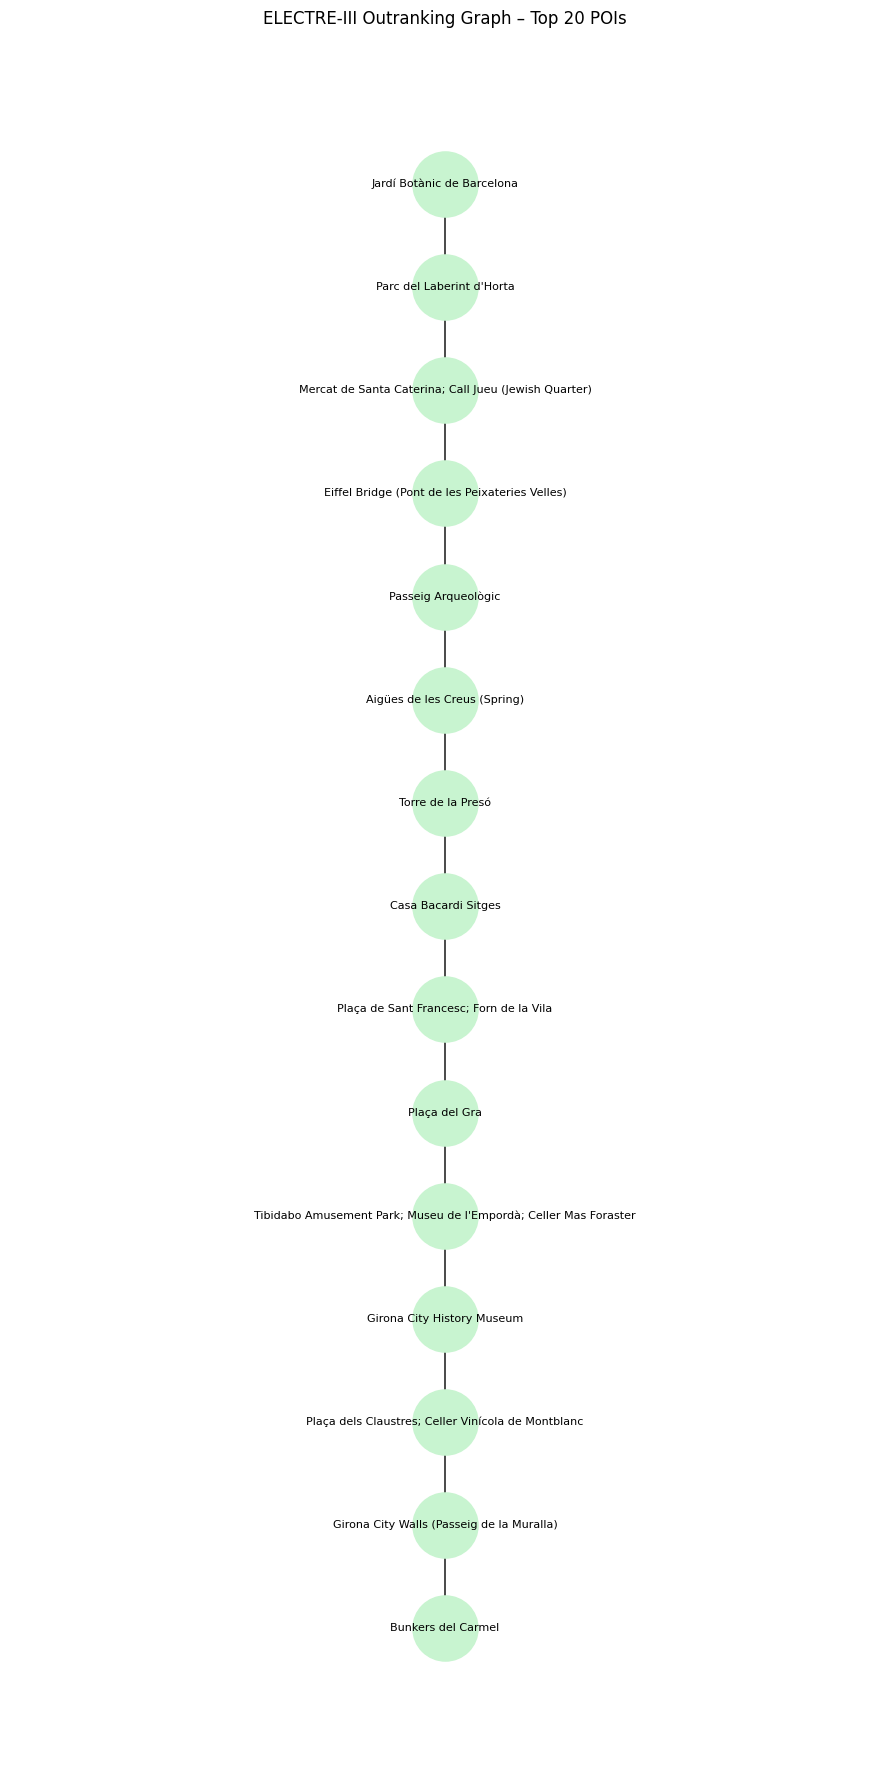

In [90]:
# ── CELL ▒▒ ELECTRE outranking – top-20 only ▒▒────────────────────────
import matplotlib.pyplot as plt
import networkx as nx

MAX_ALTS = 20        # how many individual POIs to show

# helper: "a17" -> POI name at that position
def alt_to_name(label: str) -> str:
    idx = int(label.strip()[1:]) - 1          # "a17" -> 16
    return df_valid.loc[df_valid.index[idx], "name"]

# --------------------------------------------------------------------
# Build tiers until we accumulate MAX_ALTS alternatives
tiers, alt_count = [], 0
for block in rank_D:                           # rank_D is descending
    if alt_count >= MAX_ALTS:
        break
    raw_labels = [tok.strip() for tok in block.split(";") if tok.strip()]
    names      = [alt_to_name(tok) for tok in raw_labels]
    # if adding this whole tier exceeds MAX_ALTS, truncate it
    if alt_count + len(names) > MAX_ALTS:
        names = names[: MAX_ALTS - alt_count]
    tiers.append("; ".join(names))
    alt_count += len(names)

print(f"Plotting {alt_count} alternatives across {len(tiers)} tiers")

# --------------------------------------------------------------------
# Vertical digraph: node0 (best) -> node1 -> ...
G = nx.DiGraph()
for i, txt in enumerate(tiers):
    G.add_node(i, label=txt)
    if i < len(tiers) - 1:
        G.add_edge(i, i + 1)

pos = {i: (0, -i) for i in range(len(tiers))}

plt.figure(figsize=(9, 1.2 * len(tiers)))
nx.draw_networkx_nodes(G, pos, node_color="#c8f4d0", node_size=2200)
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=14)
nx.draw_networkx_labels(
    G, pos,
    labels={i: lbl for i, lbl in G.nodes(data="label")},
    font_size=8, verticalalignment="center", horizontalalignment="center"
)
plt.title("ELECTRE-III Outranking Graph – Top 20 POIs")
plt.axis("off")
plt.tight_layout()
plt.show()


In [91]:
# ── CELL ▒▒ LSP contribution + explanation ▒▒───────────────────────────
import json, matplotlib.pyplot as plt, pandas as pd, numpy as np

rho = 0.5
criteria  = [f"z{i}" for i in range(1, 8)]
crit_names = ["CO₂", "Overtourism", "Seasonality",
              "Local-eco", "Cultural-fragility",
              "Accessibility", "Pref-fit"]      # for readability

def lsp_parts(row):
    """Return (U, contrib_vector) for a single row."""
    parts = weights * (row[criteria].values.astype(float) ** rho)
    U     = (parts.sum()) ** (1 / rho)
    return U, parts

records = []
for idx, r in kernel.iterrows():
    U, parts = lsp_parts(r)
    pct = parts / parts.sum() * 100
    top_pos = crit_names[int(pct.argmax())]
    top_neg = crit_names[int(pct.argmin())]
    natural = (f"{r['name']} scores {U:.3f}. "
               f"Main positive driver: {top_pos} ({pct.max():.1f}% of utility). "
               f"Least contributing: {top_neg} ({pct.min():.1f}%).")
    records.append({
        "name": r["name"],
        "U_LSP": U,
        "criterion_contribs": json.dumps(
            {n: round(p, 3) for n, p in zip(crit_names, pct)}
        ),
        "top_positive": top_pos,
        "top_negative": top_neg,
        "natural_lang": natural,
    })

explanations = pd.DataFrame(records)
display(explanations.head(5))          # quick peek in notebook


,name,U_LSP,criterion_contribs,top_positive,top_negative,natural_lang
0,Barcelona Cathedral,0.712501,"{""CO\u2082"": 5.994, ""Overtourism"": 13.107, ""Se...",Pref-fit,Seasonality,Barcelona Cathedral scores 0.713. Main positiv...
1,Parc de la Ciutadella,0.686734,"{""CO\u2082"": 6.106, ""Overtourism"": 11.217, ""Se...",Pref-fit,Seasonality,Parc de la Ciutadella scores 0.687. Main posit...
2,Tibidabo Amusement Park,0.627548,"{""CO\u2082"": 6.387, ""Overtourism"": 11.734, ""Se...",Pref-fit,Seasonality,Tibidabo Amusement Park scores 0.628. Main pos...
3,Bunkers del Carmel,0.606739,"{""CO\u2082"": 6.496, ""Overtourism"": 12.889, ""Se...",Pref-fit,Seasonality,Bunkers del Carmel scores 0.607. Main positive...
4,Jardí Botànic de Barcelona,0.509730,"{""CO\u2082"": 6.137, ""Overtourism"": 10.63, ""Sea...",Pref-fit,Seasonality,Jardí Botànic de Barcelona scores 0.510. Main ...


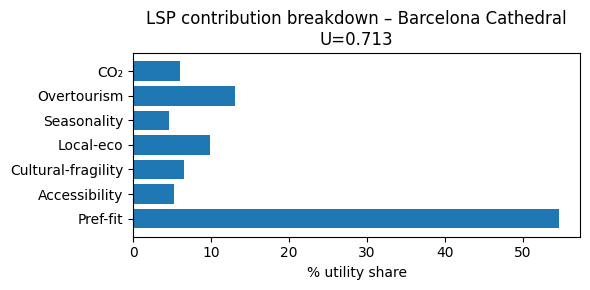

In [97]:
# pick a POI to visualise
poi = explanations.iloc[0]["name"]

row = kernel[kernel["name"] == poi].iloc[0]
U, parts = lsp_parts(row)
pct = parts / parts.sum() * 100

plt.figure(figsize=(6, 3))
plt.barh(crit_names, pct)
plt.gca().invert_yaxis()
plt.title(f"LSP contribution breakdown – {poi}\nU={U:.3f}")
plt.xlabel("% utility share")
plt.tight_layout()
plt.show()


In [101]:
# ── CELL ▒▒ Clean pair-wise & global explanations (utility deltas) ▒▒───
EPS = 0.5          # minimum share (percentage-points) to mention
N_TERMS = 3        # bullets per list

# Pre-compute Δ-utility (% share) for every POI in kernel
delta_pct = {}
for idx, row in kernel.iterrows():
    contrib = weights * (row[criteria].values.astype(float) ** rho)
    pct     = contrib / contrib.sum() * 100
    delta_pct[idx] = pct

idx2name   = kernel["name"].to_dict()
sorted_idx = kernel.sort_values("U_LSP", ascending=False).index.tolist()

def explain_pair(idx_a, idx_b, eps=EPS, n_terms=N_TERMS) -> str:
    """Natural-language why-A-beats-B explanation using +/- gaps."""
    pa, pb   = delta_pct[idx_a], delta_pct[idx_b]
    diff     = pa - pb                          # + favours A
    adv_idx  = [j for j in diff.argsort()[::-1] if diff[j] >  eps][:n_terms]
    lag_idx  = [j for j in diff.argsort()       if diff[j] < -eps][:n_terms]

    if not adv_idx and not lag_idx:
        return (f"### {idx2name[idx_a]} vs {idx2name[idx_b]}\n"
                "Scores are practically tied on every criterion "
                f"(all gaps ≤ {eps} pp).")

    lines = [f"### Why **_{idx2name[idx_a]}_** outranks **_{idx2name[idx_b]}_**"]

    for j in adv_idx:
        lines.append(f"• **{crit_names[j]}** contributes more "
                     f"({pa[j]:.1f}% vs {pb[j]:.1f}%).")
    for j in lag_idx:
        lines.append(f"• Trades off lower **{crit_names[j]}** "
                     f"({pa[j]:.1f}% vs {pb[j]:.1f}%).")
    return "\n".join(lines)

# Example: top-1 vs top-2
print(explain_pair(sorted_idx[0], sorted_idx[1]))

def global_summary(top_k=10, eps=EPS):
    """One-liner per consecutive pair of the top-k ranked POIs."""
    out = []
    for i in range(min(top_k - 1, len(sorted_idx) - 1)):
        a, b = sorted_idx[i], sorted_idx[i + 1]
        pa, pb = delta_pct[a], delta_pct[b]
        diff   = pa - pb
        mask   = np.abs(diff) > eps
        if not mask.any():
            key = f"no single standout factor (> {eps} pp)"
        else:
            j = np.argmax(np.where(mask, diff, -np.inf))
            direction = "higher" if diff[j] > 0 else "lower"
            key = (f"{direction} **{crit_names[j]}** "
                   f"({pa[j]:.1f}% vs {pb[j]:.1f}%)")
        out.append(f"{i+1}>{i+2} – _{idx2name[a]}_ over _{idx2name[b]}_: {key}.")
    return out

print(*global_summary(10), sep="\n")


### Barcelona Cathedral vs Punta de s'Alqueria
Scores are practically tied on every criterion (all gaps ≤ 0.5 pp).
1>2 – _Barcelona Cathedral_ over _Punta de s'Alqueria_: no single standout factor (> 0.5 pp).
2>3 – _Punta de s'Alqueria_ over _Parc de la Ciutadella_: higher **Pref-fit** (54.6% vs 52.3%).
3>4 – _Parc de la Ciutadella_ over _Girona City Walls (Passeig de la Muralla)_: higher **Cultural-fragility** (8.5% vs 6.7%).
4>5 – _Girona City Walls (Passeig de la Muralla)_ over _Museu Nacional d'Art de Catalunya (MNAC)_: higher **Pref-fit** (54.3% vs 53.6%).
5>6 – _Museu Nacional d'Art de Catalunya (MNAC)_ over _Girona Art Museum_: higher **Pref-fit** (53.6% vs 51.5%).
6>7 – _Girona Art Museum_ over _Passeig Arqueològic_: higher **CO₂** (7.0% vs 5.5%).
7>8 – _Passeig Arqueològic_ over _Tibidabo Amusement Park_: higher **Local-eco** (11.9% vs 10.6%).
8>9 – _Tibidabo Amusement Park_ over _Celler Mas Foraster_: no single standout factor (> 0.5 pp).
9>10 – _Celler Mas Foraster_ over _Mu

### 5️⃣ Visualise the top‑k POIs on a map
Streamlit already does this in your current `main.py`, but here’s a one‑liner with **folium** if you want to stay in‑notebook.

In [45]:
!pip install fastai

  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvid

In [ ]:
# !pip install folium --quiet
import folium, webbrowser, tempfile, uuid
from fastai.imports import *

m = folium.Map(location=[41.3851, 2.1734], zoom_start=6)
top = kernel.head(15)
for _, r in top.iterrows():
    folium.CircleMarker(
        [r['lat'], r['lon']],
        radius=6,
        popup=f"{r['name']} — U={r['U_LSP']:.2f}",
        fill=True
    ).add_to(m)

temp_path = Path(tempfile.gettempdir()) / f"greenexplorer_{uuid.uuid4().hex}.html"
m.save(temp_path)
webbrowser.open(temp_path.as_uri())
print(f"Map saved to {temp_path}")

ModuleNotFoundError: No module named 'fastai'

---
**You’re all set!**

*Next steps*
1. Wire this notebook into your Streamlit UI (call the functions in `src/`).
2. Replace the random indicator generator with real data pipelines or the ChatGPT enrichment.
3. Plug the user/group preference vector into `z7`.
4. Tune the ELECTRE thresholds & weights, then run the user study. :rocket:

In [42]:
!pip install folium

In [103]:
def f(n: int) -> int:
    """
    Port of the pseudocode function shown in the screenshot.

    Parameters
    ----------
    n : int
        Any integer (positive, zero or negative).

    Returns
    -------
    int
        The value of the running total `c` once the loop finishes.
    """
    c = 0
    while n >= 0:
        n -= 2          # step ❶ – subtract 2 from n
        c += n - 2      # step ❷ – add (n-2) **after** the decrement
    return c


In [106]:
for i in range(0, 100):
    print(f"f({i}) = {f(i)}")

f(0) = -4
f(1) = -3
f(2) = -6
f(3) = -4
f(4) = -6
f(5) = -3
f(6) = -4
f(7) = 0
f(8) = 0
f(9) = 5
f(10) = 6
f(11) = 12
f(12) = 14
f(13) = 21
f(14) = 24
f(15) = 32
f(16) = 36
f(17) = 45
f(18) = 50
f(19) = 60
f(20) = 66
f(21) = 77
f(22) = 84
f(23) = 96
f(24) = 104
f(25) = 117
f(26) = 126
f(27) = 140
f(28) = 150
f(29) = 165
f(30) = 176
f(31) = 192
f(32) = 204
f(33) = 221
f(34) = 234
f(35) = 252
f(36) = 266
f(37) = 285
f(38) = 300
f(39) = 320
f(40) = 336
f(41) = 357
f(42) = 374
f(43) = 396
f(44) = 414
f(45) = 437
f(46) = 456
f(47) = 480
f(48) = 500
f(49) = 525
f(50) = 546
f(51) = 572
f(52) = 594
f(53) = 621
f(54) = 644
f(55) = 672
f(56) = 696
f(57) = 725
f(58) = 750
f(59) = 780
f(60) = 806
f(61) = 837
f(62) = 864
f(63) = 896
f(64) = 924
f(65) = 957
f(66) = 986
f(67) = 1020
f(68) = 1050
f(69) = 1085
f(70) = 1116
f(71) = 1152
f(72) = 1184
f(73) = 1221
f(74) = 1254
f(75) = 1292
f(76) = 1326
f(77) = 1365
f(78) = 1400
f(79) = 1440
f(80) = 1476
f(81) = 1517
f(82) = 1554
f(83) = 1596
f(84) = 1634
